# ** Описание **

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице
2	Средняя длинна слова
3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [1]:
# from __future__ import division

import base64
import csv
import gzip
import zlib
import string

import pymorphy2

from collections import namedtuple

from sys import getsizeof

import re
from html.parser import HTMLParser

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from urllib.parse import urlparse

### Утилиты

#### Декораторы

In [2]:
def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a / b

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [3]:
###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [4]:
from bs4 import BeautifulSoup

def html2text_bs(raw_html):
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [5]:
html2text = html2text_bs_visible
#html2text = html2text_parser

#### Методы для токенизации текста

In [6]:
@convert2lower
# @convert2unicode
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
# @convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [7]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    text = to_text(raw_html)
    return tokenizer(text.lower()), len(html2text_bs(raw_html)) / len(text)

#### Рассчет финальных метрик

In [8]:
def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [9]:
from  more_itertools import unique_everseen

most_freq_words = []
with open('freq_words.txt', 'r') as f:
    for i in range(300):
        most_freq_words.append(f.readline().lower().strip())
morph = pymorphy2.MorphAnalyzer()
for i in range(len(most_freq_words)):
    p = morph.parse(most_freq_words[i])[0]
    most_freq_words[i] = p.normal_form
most_freq_words = list(unique_everseen(most_freq_words))

In [18]:
def calc_features(url, html_data, words, vis_unvis):
    global most_freq_words
    domens = ['ru', 'ms', 'com', 'org', 'cc', 'cz', 'ir', 'info', 
        'me', 'kz', 'net', 'ua', 'tk', 'pl', 'nu', 'su' ,'by', 'biz', 'tv']
    
    soup = BeautifulSoup(html_data, "html.parser")
    
    features = np.zeros(13 + 19)
    
    words_num = len(words)
    features[0] = words_num
    
    avg_word_len = 0
    for word in words:
        avg_word_len += len(word)
    avg_word_len = safe_divide(avg_word_len, words_num)
    features[1] = avg_word_len
    
    if hasattr(soup.title, 'text'):
        title_words_num = len(re.findall(r"[\w']+", soup.title.text))
    else:
        title_words_num = 0
    features[2] = title_words_num
    
    uncomp_size = getsizeof(html_data)
    comp_size = getsizeof(zlib.compress(html_data.encode()))
    compression_level = safe_divide(uncomp_size, comp_size)
    features[3] = compression_level
    
    js_tag_num = len(soup.find_all('script'))
    features[4] = js_tag_num
    
    slash_num = url.count('/') - 2
    features[5] = slash_num
    
    dots_num = url.count('.')
    features[6] = dots_num
    
    domen = urlparse(url).netloc.split('.')[-1]
    for i in range(len(domens)):
        if domens[i] == domen:
            features[i + 10] = 1
            
    dot = url.rfind(".")
    if url[dot + 1:] == "html" or url[dot + 1:] == "htm":
        features[7] = 1
    else:
        features[7] = 0
    
    features[8] = len(soup.find_all('img'))
    
    for anchor in soup.find_all('a'):
        if hasattr(anchor, 'text'):
            features[9] += len(anchor.text)
            
    features[10] = vis_unvis
    
    features[11] = 0
    for word in words:
        if word in most_freq_words:
            features[11] += 1
    if len(words) == 0:
        features[11] = 0
    else:
        features[11] /= len(words)
    
    features[12] = 0
    for word in most_freq_words:
        if word in words:
            features[12] += 1
    features[12] /= len(most_freq_words)
        
    return features

In [11]:
from tqdm import tqdm

In [12]:
DocItem = namedtuple('DocItem', ['doc_id', 'url', 'html', 'words'])

def load_csv(input_file_name):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm(enumerate(input_file)):
            line = line.decode()
            parts = line.strip().split('\t')
            url_id = int(parts[0])
            mark = bool(int(parts[1]))
            url = parts[2]
            pageInb64 = parts[3].encode()
            html_data = base64.b64decode(pageInb64).decode('utf8', 'ignore')
            words, unvis_size = html2word(html_data)
            words = list(words)
            yield DocItem(url_id, url, html_data, words), int(mark), unvis_size

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [13]:
test_html_data = '''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<body>
    <script></script>
    <script></script>
    <script></script>
</body>
</html>
'''
test_words, a = html2word(test_html_data)
test_words = list(test_words)
test_doc = DocItem(0, 'test_ulr.org', test_html_data, test_words)
test_sample_features = calc_features(test_doc.url, test_html_data, test_words, a)
test_sample_features

array([ 4.       ,  1.75     ,  2.       ,  2.6969697,  3.       ,
       -2.       ,  1.       ,  0.       ,  0.       ,  0.       ,
        1.85     ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ])

In [14]:
!ls

AntispamStatsSeminar.ipynb		kaggle_test_data_tab.csv.gz
AntispamStatsSeminarMultiprocess.ipynb	kaggle_train_data_tab.csv
freq_words.txt				kaggle_train_data_tab.csv.gz
kaggle_test_data_tab.csv		my_submission.csv


In [15]:
# %%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = []
y = []
vis_unvis = []
for doc, mark, a in load_csv(TRAIN_DATA_FILE):
    train_docs.append(doc)
    y.append(mark)
    vis_unvis.append(a)
    
y = np.array(y)

7044it [08:07, 14.87it/s]


In [16]:
train_docs[0]

DocItem(doc_id=-9222401963271173253, url='http://lawleader.ru/docs/32/', html='<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head>\r\n\t<meta http-equiv="Content-Type" content="text/html; charset=windows-1251" />\r\n\t<title>Договор займа, договоры, договора</title>\r\n\t<meta name="keywords" content="договоры, договора" />\r\n\t<meta name="description" content="договоры, договора" />\r\n\t<meta name="author" content="help-pro.ru" />\r\n\t<link href="/style.css" type="text/css" rel="stylesheet" />\r\n    <link type="text/css" href="/css/flick/jquery-ui-1.8.2.custom.css" rel="stylesheet" />\r\n\t\t<link rel="stylesheet" type="text/css" href="/balloontip.css" />\r\n\t<link href="http://lawleader.ru/favicon.ico" rel="shortcut icon" type="image/x-icon" />\r\n    <script type="text/javascript" src="/inc/jquery.js"></script>\r\n    <script type="text/javascript" src=

In [20]:
features_num = 13 + 19
features = np.empty((y.shape[0], features_num))
for i in tqdm(range(len(train_docs))):
    features[i] = calc_features(train_docs[i].url, train_docs[i].html, train_docs[i].words, vis_unvis[i])


 11%|█         | 744/7044 [00:31<05:00, 20.99it/s]


 21%|██        | 1496/7044 [00:58<03:15, 28.39it/s]


 32%|███▏      | 2242/7044 [01:26<02:04, 38.57it/s]


 43%|████▎     | 3008/7044 [01:54<02:49, 23.76it/s]


 54%|█████▍    | 3813/7044 [02:21<01:34, 34.13it/s]


 65%|██████▌   | 4587/7044 [02:55<01:33, 26.18it/s]


 76%|███████▌  | 5348/7044 [03:23<01:08, 24.68it/s]


 87%|████████▋ | 6132/7044 [03:53<00:45, 20.08it/s]


 98%|█████████▊| 6911/7044 [04:21<00:03, 39.65it/s]


100%|██████████| 7044/7044 [04:27<00:00, 26.31it/s]

In [21]:
features[0]

array([2.91000000e+03, 6.35463918e+00, 4.00000000e+00, 6.13740902e+00,
       7.00000000e+00, 3.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       8.00000000e+00, 1.40000000e+03, 1.00228281e+00, 3.48797251e-01,
       4.35714286e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [22]:
y[0]

0

/home/svasilyev/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


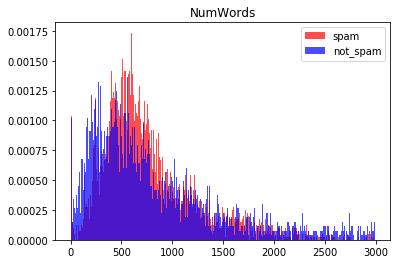

In [23]:
is_spam_data = [features[i, 0] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 0] for i in range(y.shape[0]) if y[i] == 0]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

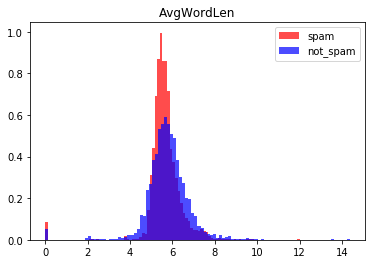

In [24]:
is_spam_data = [features[i, 1] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 1] for i in range(y.shape[0]) if y[i] == 0]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

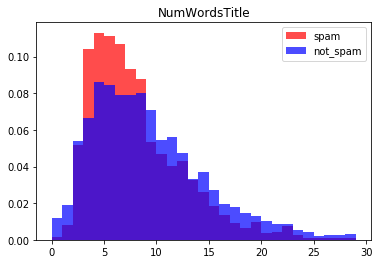

In [25]:
is_spam_data = [features[i, 2] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 2] for i in range(y.shape[0]) if y[i] == 0]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

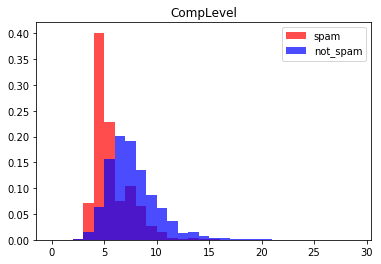

In [26]:
is_spam_data = [features[i, 3] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 3] for i in range(y.shape[0]) if y[i] == 0]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('CompLevel')
plt.legend()
plt.show()

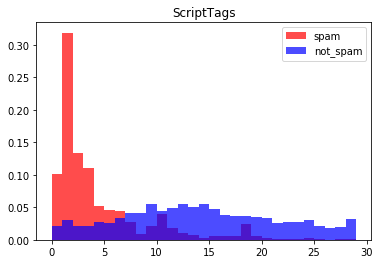

In [27]:
is_spam_data = [features[i, 4] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 4] for i in range(y.shape[0]) if y[i] == 0]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('ScriptTags')
plt.legend()
plt.show()

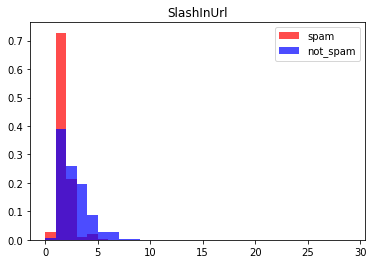

In [28]:
is_spam_data = [features[i, 5] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 5] for i in range(y.shape[0]) if y[i] == 0]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('SlashInUrl')
plt.legend()
plt.show()

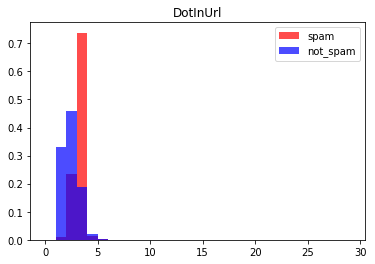

In [29]:
is_spam_data = [features[i, 6] for i in range(y.shape[0]) if y[i] == 1]
not_spam_data = [features[i, 6] for i in range(y.shape[0]) if y[i] == 0]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('DotInUrl')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [30]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [31]:
class Classifier:
    
    def __init__(self):
        self.clf = XGBClassifier(n_estimators = 1000, 
            min_samples_split = 4, max_depth = 3, learning_rate=0.1)

    def predict(self, X):        
        return self.clf.predict(np.array([X]))                    
    
    def predict_all(self, X):
        return self.clf.predict(X)
    
    def train(self, X, y):                
        self.clf.fit(X, y)

In [32]:
train_features = features[:6000]
# tr_train_features = scaler.transform(train_features)
train_y = y[:6000]
test_features = features[6000:]
# tr_test_features = scaler.transform(test_features)
test_y = y[6000:]

In [33]:
classifier = Classifier()
classifier.train(train_features, train_y)

In [34]:
pred = classifier.predict_all(test_features)

In [35]:
(pred == test_y).sum()/pred.shape[0]

0.9683908045977011

In [36]:
f1_score(test_y, pred)

0.9731051344743277

In [37]:
classifier = Classifier()
classifier.train(features, y)

In [38]:
!ls

AntispamStatsSeminar.ipynb		kaggle_test_data_tab.csv.gz
AntispamStatsSeminarMultiprocess.ipynb	kaggle_train_data_tab.csv
freq_words.txt				kaggle_train_data_tab.csv.gz
kaggle_test_data_tab.csv		my_submission.csv


In [39]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

submit_docs = []
vis_unvis_submit = []
for doc, mark, a in load_csv(TEST_DATA_FILE):
    submit_docs.append(doc)
    vis_unvis_submit.append(a)


0it [00:00, ?it/s]
4it [00:00, 10.32it/s]
7it [00:00,  9.29it/s]
11it [00:01, 10.69it/s]
12it [00:01,  6.73it/s]
15it [00:01,  8.31it/s]
17it [00:02,  3.30it/s]
21it [00:03,  4.46it/s]
24it [00:03,  4.72it/s]
26it [00:03,  6.12it/s]
28it [00:03,  7.27it/s]
30it [00:05,  2.50it/s]
33it [00:06,  3.42it/s]
35it [00:06,  4.54it/s]
37it [00:06,  4.38it/s]
40it [00:06,  5.10it/s]
43it [00:07,  6.52it/s]
45it [00:07,  7.49it/s]
50it [00:07,  9.97it/s]
53it [00:07, 11.96it/s]
56it [00:07, 14.21it/s]
61it [00:07, 17.36it/s]
64it [00:07, 19.83it/s]
67it [00:08, 11.25it/s]
71it [00:08, 14.12it/s]
74it [00:08, 13.34it/s]
77it [00:08, 15.38it/s]
80it [00:09,  9.03it/s]
82it [00:09,  9.73it/s]
85it [00:09, 11.40it/s]
89it [00:10, 14.12it/s]
92it [00:11,  5.38it/s]
94it [00:11,  5.23it/s]
97it [00:11,  6.73it/s]
99it [00:12,  7.42it/s]
101it [00:12,  8.62it/s]
103it [00:12,  9.83it/s]
105it [00:12,  7.24it/s]
108it [00:13,  9.04it/s]
112it [00:13, 11.62it/s]
115it [00:13, 13.16it/s]
117it [00:13, 14

828it [01:20,  4.87it/s]
830it [01:21,  4.25it/s]
832it [01:21,  5.37it/s]
836it [01:21,  6.94it/s]
838it [01:22,  8.38it/s]
841it [01:22, 10.69it/s]
843it [01:22,  8.21it/s]
846it [01:22,  9.58it/s]
850it [01:22, 11.81it/s]
852it [01:22, 12.37it/s]
856it [01:23, 15.57it/s]
861it [01:23, 18.87it/s]
864it [01:23, 12.77it/s]
867it [01:23, 14.32it/s]
872it [01:23, 18.08it/s]
875it [01:25,  5.00it/s]
878it [01:25,  6.57it/s]
883it [01:25,  8.63it/s]
886it [01:26,  9.45it/s]
889it [01:26, 11.47it/s]
892it [01:26, 13.59it/s]
895it [01:27,  5.41it/s]
897it [01:28,  3.22it/s]
901it [01:28,  4.43it/s]
905it [01:29,  5.97it/s]
909it [01:29,  7.89it/s]
912it [01:29,  9.51it/s]
915it [01:30,  6.22it/s]
917it [01:30,  6.95it/s]
920it [01:30,  6.75it/s]
922it [01:31,  8.31it/s]
925it [01:31, 10.28it/s]
929it [01:31, 13.22it/s]
933it [01:31, 16.27it/s]
936it [01:31, 18.45it/s]
936it [01:45, 18.45it/s]
937it [02:15, 13.20s/it]
940it [02:15,  9.26s/it]
943it [02:15,  6.49s/it]
945it [02:15,  4.56s/it]


1682it [03:59, 11.65it/s]
1685it [03:59, 13.49it/s]
1687it [04:00,  6.48it/s]
1690it [04:00,  7.88it/s]
1695it [04:00,  9.90it/s]
1697it [04:00, 10.38it/s]
1699it [04:01,  6.29it/s]
1704it [04:01,  8.42it/s]
1708it [04:01, 10.59it/s]
1711it [04:01, 12.13it/s]
1716it [04:01, 15.68it/s]
1719it [04:02, 10.39it/s]
1722it [04:02, 12.31it/s]
1725it [04:02, 14.43it/s]
1729it [04:02, 17.57it/s]
1732it [04:03, 16.78it/s]
1735it [04:03, 18.62it/s]
1738it [04:03, 10.83it/s]
1740it [04:03, 11.31it/s]
1742it [04:03, 12.87it/s]
1747it [04:04, 16.16it/s]
1750it [04:04, 18.71it/s]
1753it [04:04,  9.85it/s]
1758it [04:04, 12.78it/s]
1762it [04:05, 15.20it/s]
1765it [04:05, 16.48it/s]
1768it [04:05, 18.53it/s]
1772it [04:05, 21.82it/s]
1775it [04:05, 22.52it/s]
1779it [04:06, 15.04it/s]
1782it [04:06, 15.45it/s]
1785it [04:06, 17.95it/s]
1788it [04:06, 17.29it/s]
1791it [04:07,  7.20it/s]
1794it [04:07,  8.98it/s]
1797it [04:07, 11.24it/s]
1800it [04:08,  8.75it/s]
1802it [04:08,  9.60it/s]
1804it [04:0

2535it [05:24, 19.85it/s]
2538it [05:24,  9.47it/s]
2540it [05:24, 10.34it/s]
2544it [05:25, 12.73it/s]
2547it [05:25, 12.07it/s]
2550it [05:25, 14.23it/s]
2552it [05:26,  5.45it/s]
2556it [05:26,  7.21it/s]
2559it [05:26,  9.08it/s]
2562it [05:27,  7.88it/s]
2564it [05:27,  9.00it/s]
2566it [05:27,  9.90it/s]
2570it [05:27, 12.17it/s]
2572it [05:28,  7.80it/s]
2575it [05:28,  9.97it/s]
2579it [05:28, 12.39it/s]
2584it [05:28, 15.79it/s]
2589it [05:28, 19.62it/s]
2593it [05:29, 13.75it/s]
2596it [05:29, 15.69it/s]
2601it [05:30,  8.18it/s]
2605it [05:30, 10.74it/s]
2609it [05:30, 13.46it/s]
2614it [05:30, 16.19it/s]
2617it [05:31, 15.33it/s]
2621it [05:31, 18.64it/s]
2626it [05:31, 14.52it/s]
2629it [05:31, 16.94it/s]
2632it [05:31, 18.74it/s]
2635it [05:32, 19.89it/s]
2638it [05:32, 21.01it/s]
2642it [05:32, 23.26it/s]
2645it [05:32, 18.20it/s]
2648it [05:32, 20.59it/s]
2651it [05:32, 21.47it/s]
2654it [05:32, 22.17it/s]
2657it [05:33, 10.65it/s]
2661it [05:33, 13.23it/s]
2665it [05:3

3368it [06:36, 10.40it/s]
3370it [06:37,  5.83it/s]
3373it [06:38,  5.72it/s]
3375it [06:38,  6.90it/s]
3379it [06:38,  9.12it/s]
3384it [06:38, 11.88it/s]
3389it [06:38, 15.12it/s]
3393it [06:38, 18.47it/s]
3397it [06:38, 19.86it/s]
3401it [06:38, 22.18it/s]
3405it [06:39, 12.67it/s]
3410it [06:39, 15.43it/s]
3414it [06:39, 18.90it/s]
3417it [06:40, 19.16it/s]
3421it [06:40, 20.04it/s]
3424it [06:40, 11.32it/s]
3426it [06:40, 12.90it/s]
3428it [06:40, 13.12it/s]
3430it [06:41, 10.09it/s]
3433it [06:41,  8.56it/s]
3436it [06:41,  9.57it/s]
3439it [06:42, 10.79it/s]
3441it [06:42, 11.98it/s]
3443it [06:42,  6.84it/s]
3445it [06:43,  7.52it/s]
3447it [06:43,  8.65it/s]
3449it [06:43, 10.41it/s]
3452it [06:43, 12.46it/s]
3454it [06:43, 13.51it/s]
3456it [06:44,  7.69it/s]
3459it [06:44,  9.72it/s]
3462it [06:44, 11.72it/s]
3465it [06:44, 14.26it/s]
3468it [06:44, 15.90it/s]
3471it [06:44, 16.16it/s]
3474it [06:45,  9.75it/s]
3476it [06:45, 11.06it/s]
3480it [06:45, 13.70it/s]
3483it [06:4

4222it [07:53, 14.37it/s]
4225it [07:54, 16.49it/s]
4228it [07:54, 18.22it/s]
4231it [07:54, 19.39it/s]
4234it [07:54, 21.23it/s]
4237it [07:54, 22.03it/s]
4240it [07:55, 11.21it/s]
4243it [07:55, 12.39it/s]
4245it [07:55, 11.94it/s]
4248it [07:55, 14.45it/s]
4252it [07:55, 17.22it/s]
4255it [07:56, 10.11it/s]
4257it [07:56, 11.55it/s]
4261it [07:56, 13.91it/s]
4265it [07:56, 17.22it/s]
4268it [07:56, 18.34it/s]
4271it [07:57,  9.48it/s]
4273it [07:57, 10.58it/s]
4275it [07:57, 12.24it/s]
4279it [07:57, 14.85it/s]
4282it [07:57, 17.43it/s]
4285it [07:58, 19.70it/s]
4288it [07:58, 20.68it/s]
4291it [07:58, 10.47it/s]
4293it [07:59, 11.07it/s]
4296it [07:59, 12.66it/s]
4298it [07:59, 14.22it/s]
4301it [07:59, 16.55it/s]
4305it [07:59, 18.54it/s]
4309it [07:59, 21.40it/s]
4313it [07:59, 22.76it/s]
4316it [08:00, 10.82it/s]
4319it [08:00, 13.27it/s]
4322it [08:00, 14.67it/s]
4326it [08:00, 17.83it/s]
4329it [08:01, 16.01it/s]
4332it [08:01,  9.88it/s]
4335it [08:01, 12.32it/s]
4338it [08:0

5120it [09:06, 12.26it/s]
5125it [09:07, 11.61it/s]
5128it [09:07, 14.00it/s]
5131it [09:07,  9.65it/s]
5136it [09:08, 12.60it/s]
5140it [09:08, 15.70it/s]
5143it [09:08, 16.82it/s]
5146it [09:09,  8.04it/s]
5149it [09:09, 10.08it/s]
5153it [09:09, 12.97it/s]
5156it [09:09, 14.51it/s]
5160it [09:09, 17.00it/s]
5163it [09:09, 16.46it/s]
5166it [09:10,  8.77it/s]
5170it [09:10, 10.68it/s]
5176it [09:10, 13.47it/s]
5179it [09:11, 15.43it/s]
5182it [09:11, 17.32it/s]
5186it [09:11, 20.77it/s]
5189it [09:11, 10.68it/s]
5192it [09:12, 11.56it/s]
5196it [09:12, 14.27it/s]
5200it [09:12, 17.67it/s]
5203it [09:12, 20.04it/s]
5206it [09:14,  4.09it/s]
5209it [09:14,  5.41it/s]
5212it [09:14,  7.07it/s]
5215it [09:14,  8.84it/s]
5218it [09:15, 10.35it/s]
5221it [09:15,  7.61it/s]
5225it [09:15, 10.02it/s]
5228it [09:16, 11.38it/s]
5231it [09:16, 11.84it/s]
5234it [09:16, 14.45it/s]
5237it [09:16, 15.39it/s]
5240it [09:16, 15.04it/s]
5242it [09:17,  7.06it/s]
5245it [09:17,  8.61it/s]
5247it [09:1

5990it [11:06, 10.99it/s]
5993it [11:07, 13.25it/s]
5996it [11:07,  9.06it/s]
5999it [11:07, 11.36it/s]
6002it [11:07, 12.59it/s]
6004it [11:07, 13.81it/s]
6007it [11:08, 16.00it/s]
6010it [11:08, 17.86it/s]
6013it [11:08, 19.62it/s]
6016it [11:08, 20.99it/s]
6019it [11:08, 22.10it/s]
6022it [11:09, 11.12it/s]
6025it [11:09, 13.36it/s]
6029it [11:09, 16.50it/s]
6032it [11:09, 18.48it/s]
6035it [11:09, 18.24it/s]
6038it [11:09, 16.15it/s]
6040it [11:10,  8.03it/s]
6042it [11:10,  9.77it/s]
6045it [11:10,  8.75it/s]
6047it [11:11,  5.71it/s]
6049it [11:11,  6.71it/s]
6052it [11:11,  8.68it/s]
6054it [11:12,  9.44it/s]
6057it [11:12, 11.55it/s]
6061it [11:12,  9.24it/s]
6063it [11:13,  8.37it/s]
6066it [11:13, 10.63it/s]
6071it [11:13, 13.91it/s]
6074it [11:13, 14.68it/s]
6077it [11:13, 16.82it/s]
6080it [11:14, 10.22it/s]
6082it [11:14, 11.87it/s]
6085it [11:14, 14.31it/s]
6088it [11:14, 16.44it/s]
6091it [11:14, 18.56it/s]
6094it [11:14, 17.02it/s]
6097it [11:14, 18.77it/s]
6100it [11:1

6834it [12:24, 14.43it/s]
6837it [12:24, 15.43it/s]
6839it [12:24, 15.77it/s]
6841it [12:25,  6.27it/s]
6843it [12:25,  7.51it/s]
6847it [12:25,  9.67it/s]
6850it [12:25, 11.91it/s]
6853it [12:25, 13.51it/s]
6856it [12:26,  7.23it/s]
6860it [12:26,  9.48it/s]
6864it [12:26, 11.98it/s]
6867it [12:27, 14.36it/s]
6870it [12:27,  8.55it/s]
6874it [12:27, 10.91it/s]
6878it [12:27, 13.80it/s]
6882it [12:28, 16.84it/s]
6885it [12:28, 18.04it/s]
6889it [12:28, 21.01it/s]
6892it [12:28, 17.47it/s]
6895it [12:28, 18.29it/s]
6898it [12:29,  9.62it/s]
6902it [12:29, 12.34it/s]
6905it [12:29, 14.47it/s]
6908it [12:29, 16.76it/s]
6911it [12:29, 18.78it/s]
6914it [12:29, 18.41it/s]
6917it [12:30, 18.55it/s]
6921it [12:30, 20.76it/s]
6924it [12:31,  8.33it/s]
6928it [12:31, 10.61it/s]
6931it [12:31, 12.92it/s]
6935it [12:31, 15.46it/s]
6938it [12:32,  8.26it/s]
6940it [12:32,  9.68it/s]
6943it [12:32, 12.13it/s]
6946it [12:32, 13.43it/s]
6949it [12:33,  8.54it/s]
6951it [12:33,  9.23it/s]
6953it [12:3

7705it [13:47, 15.90it/s]
7708it [13:47, 18.14it/s]
7711it [13:48, 15.06it/s]
7716it [13:48, 17.73it/s]
7719it [13:49,  8.80it/s]
7721it [13:49,  8.99it/s]
7724it [13:49, 11.32it/s]
7727it [13:49, 13.83it/s]
7730it [13:50,  7.99it/s]
7733it [13:50,  9.88it/s]
7737it [13:50, 10.93it/s]
7739it [13:50, 10.04it/s]
7741it [13:51,  5.95it/s]
7743it [13:51,  7.07it/s]
7745it [13:51,  8.37it/s]
7748it [13:51, 10.34it/s]
7751it [13:52, 12.78it/s]
7754it [13:52, 14.75it/s]
7757it [13:52,  8.61it/s]
7760it [13:52, 10.77it/s]
7762it [13:53, 11.59it/s]
7765it [13:53, 13.22it/s]
7768it [13:53, 15.48it/s]
7773it [13:53, 18.66it/s]
7777it [13:53, 20.97it/s]
7782it [13:53, 21.44it/s]
7785it [13:54,  7.22it/s]
7787it [13:55,  8.91it/s]
7790it [13:55, 11.19it/s]
7793it [13:55,  7.93it/s]
7796it [13:55,  9.89it/s]
7799it [13:56, 11.88it/s]
7801it [13:56,  9.11it/s]
7803it [13:56,  5.91it/s]
7805it [13:57,  7.46it/s]
7808it [13:57,  9.33it/s]
7812it [13:57, 11.84it/s]
7815it [13:57, 13.09it/s]
7818it [13:5

8632it [15:12,  2.00it/s]
8634it [15:12,  2.69it/s]
8637it [15:12,  3.53it/s]
8641it [15:13,  4.47it/s]
8643it [15:13,  3.69it/s]
8646it [15:14,  4.14it/s]
8649it [15:14,  5.58it/s]
8651it [15:15,  4.49it/s]
8657it [15:15,  6.08it/s]
8659it [15:15,  7.35it/s]
8663it [15:15,  9.71it/s]
8668it [15:15, 12.72it/s]
8672it [15:17,  5.17it/s]
8676it [15:17,  6.75it/s]
8679it [15:17,  8.75it/s]
8682it [15:17, 10.31it/s]
8685it [15:18, 12.62it/s]
8688it [15:18, 15.09it/s]
8691it [15:18, 17.38it/s]
8695it [15:18, 20.67it/s]
8698it [15:19,  7.24it/s]
8702it [15:19,  9.42it/s]
8705it [15:22,  3.07it/s]
8707it [15:22,  3.96it/s]
8710it [15:22,  4.03it/s]
8715it [15:23,  5.55it/s]
8718it [15:23,  7.12it/s]
8721it [15:23,  8.15it/s]
8725it [15:23, 10.67it/s]
8729it [15:24,  8.61it/s]
8731it [15:24,  9.91it/s]
8735it [15:24, 12.65it/s]
8738it [15:24, 15.05it/s]
8741it [15:24, 17.45it/s]
8746it [15:24, 21.62it/s]
8750it [15:25, 10.69it/s]
8753it [15:25, 12.19it/s]
8756it [15:25, 14.78it/s]
8759it [15:2

9524it [17:01,  8.71it/s]
9527it [17:01, 10.70it/s]
9530it [17:01, 12.89it/s]
9533it [17:01, 14.89it/s]
9536it [17:01, 15.13it/s]
9539it [17:01, 16.81it/s]
9542it [17:02, 18.83it/s]
9545it [17:02,  9.48it/s]
9547it [17:02, 11.10it/s]
9549it [17:03, 11.37it/s]
9551it [17:03, 12.05it/s]
9554it [17:03, 13.23it/s]
9557it [17:03, 14.80it/s]
9560it [17:03, 17.31it/s]
9563it [17:04,  8.75it/s]
9567it [17:04, 11.10it/s]
9571it [17:04, 13.96it/s]
9574it [17:04, 15.20it/s]
9577it [17:05,  7.23it/s]
9580it [17:05,  9.23it/s]
9584it [17:05, 11.73it/s]
9587it [17:06, 13.24it/s]
9590it [17:06, 15.52it/s]
9594it [17:06, 18.05it/s]
9597it [17:06, 18.24it/s]
9600it [17:07,  7.49it/s]
9605it [17:07,  9.80it/s]
9608it [17:07, 12.26it/s]
9611it [17:07, 14.37it/s]
9614it [17:09,  5.47it/s]
9617it [17:09,  7.19it/s]
9620it [17:09,  9.08it/s]
9623it [17:10,  7.05it/s]
9626it [17:10,  9.15it/s]
9629it [17:10,  9.82it/s]
9633it [17:10, 12.56it/s]
9636it [17:10, 15.06it/s]
9639it [17:13,  3.15it/s]
9641it [17:1

10392it [19:04, 19.42it/s]
10395it [19:05,  8.18it/s]
10398it [19:05, 10.30it/s]
10401it [19:05, 10.27it/s]
10403it [19:06,  5.38it/s]
10407it [19:06,  7.15it/s]
10410it [19:06,  8.84it/s]
10413it [19:09,  2.85it/s]
10416it [19:09,  3.89it/s]
10419it [19:09,  5.20it/s]
10423it [19:09,  6.75it/s]
10427it [19:10,  8.90it/s]
10430it [19:10,  9.92it/s]
10433it [19:11,  6.58it/s]
10436it [19:11,  8.33it/s]
10440it [19:11, 10.88it/s]
10443it [19:11, 13.13it/s]
10446it [19:11, 15.67it/s]
10450it [19:11, 18.06it/s]
10453it [19:11, 19.76it/s]
10456it [19:15,  2.67it/s]
10460it [19:15,  3.70it/s]
10463it [19:15,  4.68it/s]
10466it [19:15,  5.95it/s]
10468it [19:16,  4.18it/s]
10474it [19:16,  5.76it/s]
10477it [19:16,  6.86it/s]
10481it [19:17,  8.36it/s]
10483it [19:17,  5.18it/s]
10485it [19:18,  6.56it/s]
10487it [19:18,  8.03it/s]
10490it [19:18,  9.95it/s]
10492it [19:18,  9.60it/s]
10494it [19:19,  5.15it/s]
10498it [19:19,  6.89it/s]
10502it [19:19,  8.96it/s]
10507it [19:19, 11.50it/s]
1

11271it [20:29, 10.26it/s]
11273it [20:29, 12.02it/s]
11275it [20:29,  6.02it/s]
11278it [20:29,  7.76it/s]
11281it [20:30,  9.63it/s]
11286it [20:30, 12.49it/s]
11289it [20:32,  3.03it/s]
11292it [20:33,  4.08it/s]
11294it [20:34,  3.13it/s]
11297it [20:34,  4.14it/s]
11299it [20:34,  4.78it/s]
11302it [20:34,  6.32it/s]
11304it [20:35,  4.49it/s]
11307it [20:35,  6.01it/s]
11311it [20:35,  7.98it/s]
11315it [20:35, 10.37it/s]
11319it [20:35, 12.78it/s]
11322it [20:35, 15.37it/s]
11325it [20:36, 17.59it/s]
11328it [20:36, 18.23it/s]
11331it [20:36, 15.02it/s]
11335it [20:37,  9.53it/s]
11337it [20:37, 11.12it/s]
11339it [20:37, 11.16it/s]
11341it [20:37, 12.02it/s]
11344it [20:37, 14.39it/s]
11347it [20:38, 15.56it/s]
11349it [20:38, 16.37it/s]
11352it [20:38,  8.50it/s]
11355it [20:38, 10.81it/s]
11359it [20:39, 13.78it/s]
11362it [20:39, 15.73it/s]
11365it [20:39, 16.92it/s]
11368it [20:45,  1.45it/s]
11373it [20:45,  2.04it/s]
11376it [20:46,  2.73it/s]
11378it [20:46,  3.35it/s]
1

12156it [21:57, 11.33it/s]
12158it [21:57, 12.74it/s]
12163it [21:59,  7.28it/s]
12168it [21:59,  9.71it/s]
12172it [22:00,  7.30it/s]
12174it [22:00,  8.69it/s]
12176it [22:00,  8.91it/s]
12178it [22:00, 10.09it/s]
12182it [22:00, 12.34it/s]
12184it [22:01,  5.20it/s]
12188it [22:02,  6.77it/s]
12191it [22:02,  8.74it/s]
12195it [22:02, 11.26it/s]
12198it [22:03,  6.88it/s]
12201it [22:03,  8.93it/s]
12204it [22:03, 10.92it/s]
12207it [22:03, 11.60it/s]
12210it [22:03, 13.27it/s]
12216it [22:03, 17.05it/s]
12219it [22:04,  8.54it/s]
12223it [22:04, 10.95it/s]
12226it [22:04, 13.32it/s]
12230it [22:04, 15.87it/s]
12234it [22:05, 18.94it/s]
12239it [22:05, 23.05it/s]
12243it [22:06,  9.06it/s]
12246it [22:06, 11.41it/s]
12249it [22:06, 10.08it/s]
12252it [22:06, 12.34it/s]
12255it [22:07,  7.47it/s]
12260it [22:07,  9.93it/s]
12263it [22:07, 10.51it/s]
12266it [22:08, 12.11it/s]
12269it [22:08,  7.10it/s]
12273it [22:09,  9.37it/s]
12276it [22:09, 11.48it/s]
12282it [22:09, 15.07it/s]
1

13055it [23:23, 12.82it/s]
13061it [23:23, 15.97it/s]
13064it [23:24,  8.43it/s]
13068it [23:24, 10.83it/s]
13071it [23:24, 11.76it/s]
13074it [23:24, 14.00it/s]
13077it [23:25, 16.58it/s]
13082it [23:25, 20.59it/s]
13086it [23:25, 21.80it/s]
13089it [23:25, 18.60it/s]
13094it [23:25, 21.87it/s]
13097it [23:26,  8.75it/s]
13100it [23:26, 10.40it/s]
13103it [23:26, 11.27it/s]
13107it [23:26, 13.47it/s]
13110it [23:27, 14.51it/s]
13113it [23:27, 16.90it/s]
13116it [23:27, 16.80it/s]
13119it [23:28,  7.49it/s]
13122it [23:28,  8.65it/s]
13124it [23:29,  4.37it/s]
13130it [23:29,  6.01it/s]
13133it [23:29,  7.31it/s]
13135it [23:31,  2.90it/s]
13137it [23:31,  3.90it/s]
13139it [23:32,  3.45it/s]
13142it [23:32,  4.70it/s]
13145it [23:32,  5.91it/s]
13148it [23:32,  7.77it/s]
13151it [23:32,  9.60it/s]
13154it [23:33,  5.98it/s]
13157it [23:34,  7.04it/s]
13160it [23:34,  9.06it/s]
13164it [23:34, 11.62it/s]
13167it [23:35,  5.87it/s]
13170it [23:35,  7.65it/s]
13175it [23:38,  3.90it/s]
1

13907it [25:00,  1.46it/s]
13908it [25:00,  1.94it/s]
13911it [25:00,  2.68it/s]
13914it [25:01,  2.92it/s]
13916it [25:01,  3.87it/s]
13921it [25:01,  5.33it/s]
13924it [25:01,  6.85it/s]
13927it [25:03,  4.31it/s]
13929it [25:03,  5.58it/s]
13932it [25:04,  4.96it/s]
13936it [25:04,  6.68it/s]
13938it [25:04,  8.07it/s]
13942it [25:04,  9.99it/s]
13944it [25:05,  3.98it/s]
13946it [25:05,  4.91it/s]
13948it [25:06,  6.21it/s]
13950it [25:06,  4.20it/s]
13953it [25:07,  5.59it/s]
13955it [25:07,  6.84it/s]
13959it [25:07,  8.90it/s]
13961it [25:07, 10.64it/s]
13963it [25:07, 12.20it/s]
13966it [25:07, 14.80it/s]
13970it [25:07, 17.94it/s]
13973it [25:07, 16.46it/s]
13976it [25:08,  7.10it/s]
13979it [25:09,  8.82it/s]
13982it [25:09, 10.67it/s]
13984it [25:09, 11.77it/s]
13986it [25:09, 12.95it/s]
13988it [25:09, 13.13it/s]
13991it [25:09, 15.26it/s]
13995it [25:09, 18.39it/s]
13998it [25:09, 18.99it/s]
14001it [25:10,  7.55it/s]
14003it [25:11,  8.60it/s]
14005it [25:11,  9.75it/s]
1

14711it [26:34,  9.93it/s]
14714it [26:35,  5.28it/s]
14718it [26:35,  6.58it/s]
14720it [26:35,  8.23it/s]
14723it [26:36,  9.96it/s]
14726it [26:36, 12.44it/s]
14730it [26:36, 14.99it/s]
14733it [26:36, 17.10it/s]
14736it [26:37,  7.09it/s]
14739it [26:37,  8.64it/s]
14741it [26:38,  6.85it/s]
14743it [26:38,  4.23it/s]
14745it [26:39,  5.46it/s]
14748it [26:39,  6.80it/s]
14750it [26:39,  8.01it/s]
14753it [26:39,  9.99it/s]
14755it [26:39,  9.94it/s]
14757it [26:40,  5.29it/s]
14760it [26:40,  6.93it/s]
14763it [26:40,  9.01it/s]
14765it [26:40,  9.20it/s]
14768it [26:41, 10.66it/s]
14770it [26:41, 12.25it/s]
14773it [26:42,  6.62it/s]
14776it [26:42,  8.53it/s]
14781it [26:42, 11.12it/s]
14784it [26:42, 13.22it/s]
14788it [26:42, 13.63it/s]
14791it [26:43,  7.37it/s]
14795it [26:43,  9.39it/s]
14799it [26:43, 12.07it/s]
14803it [26:45,  5.99it/s]
14805it [26:45,  7.10it/s]
14809it [26:45,  8.95it/s]
14811it [26:46,  4.48it/s]
14814it [26:46,  5.80it/s]
14817it [26:46,  7.32it/s]
1

15539it [28:08, 11.13it/s]
15542it [28:09, 13.32it/s]
15544it [28:09, 14.55it/s]
15548it [28:09, 17.85it/s]
15551it [28:10,  7.31it/s]
15555it [28:10,  9.40it/s]
15559it [28:10, 12.16it/s]
15563it [28:10, 15.16it/s]
15566it [28:11,  6.02it/s]
15569it [28:13,  3.44it/s]
15574it [28:13,  4.74it/s]
15577it [28:13,  6.25it/s]
15580it [28:13,  8.19it/s]
15586it [28:14, 10.72it/s]
15589it [28:14, 12.56it/s]
15593it [28:14, 15.68it/s]
15596it [28:14, 14.79it/s]
15600it [28:16,  5.98it/s]
15602it [28:16,  7.19it/s]
15604it [28:16,  8.42it/s]
15607it [28:17,  5.77it/s]
15610it [28:17,  7.55it/s]
15613it [28:17,  9.60it/s]
15617it [28:17, 12.38it/s]
15621it [28:17, 15.36it/s]
15624it [28:18,  6.41it/s]
15628it [28:19,  8.17it/s]
15632it [28:26,  1.64it/s]
15635it [28:26,  2.28it/s]
15638it [28:26,  3.15it/s]
15643it [28:26,  4.19it/s]
15646it [28:26,  5.32it/s]
15648it [28:27,  3.56it/s]
15650it [28:27,  4.72it/s]
15654it [28:34,  1.47it/s]
15660it [28:35,  2.07it/s]
15663it [28:35,  2.83it/s]
1

In [40]:
len(submit_docs)

16039

In [ ]:
submit_features = np.empty((len(submit_docs), features_num))
for i in tqdm(range(len(submit_docs))):
    submit_features[i] = calc_features(submit_docs[i].url, submit_docs[i].html, submit_docs[i].words, vis_unvis_submit[i])


  4%|▍         | 641/16039 [00:47<13:49, 18.57it/s]


  7%|▋         | 1068/16039 [01:45<09:15, 26.96it/s]

In [ ]:
submit_pred = classifier.predict_all(submit_features)

In [ ]:
with open('my_submission.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for i in range(len(submit_docs)):
        writer.writerow([submit_docs[i].doc_id, submit_pred[i]])